# AIN 214 - PA5 - 2023 on Clustering

This homework aims to deepen your understanding of clustering algorithms and introduce the concept of dimensionality reduction using Principal Component Analysis (PCA). You will use K-Means and Agglomerative Clustering, and explore the impact of PCA on these clustering techniques.



# Student Info
## Name Surname: \<Sümeyra Koç>
## Student ID: \<2210765020>


## Dataset

We will use the Mall Customer Segmentation Data from Kaggle. The dataset is added to the homework folder - also accessible at [here](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/).
 

In [146]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler # to normalization
from sklearn.decomposition import PCA # apply PCA
from sklearn.cluster import KMeans # k-means
from scipy.cluster.hierarchy import dendrogram, linkage # apply HAC
from sklearn.metrics import silhouette_score # Evaluate clusters

## 1. Data Cleaning

* **Objective**: Prepare your dataset for analysis.
* **Tasks**: Handle missing values, encode categorical features, handle outliers.

The steps for data cleaning may vary. I do not expect you to use a spefisific algorithm to handle outliers for example. But **show your work!**


In [147]:
# Load the dataset
data = pd.read_csv("Mall_Customers.csv")
mall_customers_data = pd.DataFrame(data)
mall_customers_data

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [148]:
# Handle missing values and outliers
mall_customers_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

There is no missing values in the data.


For a dataset with features like "CustomerID," "Gender," "Age," "Annual Income (k$)," and "Spending Score (1-100)," we want to focus on identifying outliers in the numerical columns, such as "Age," "Annual Income," and "Spending Score."

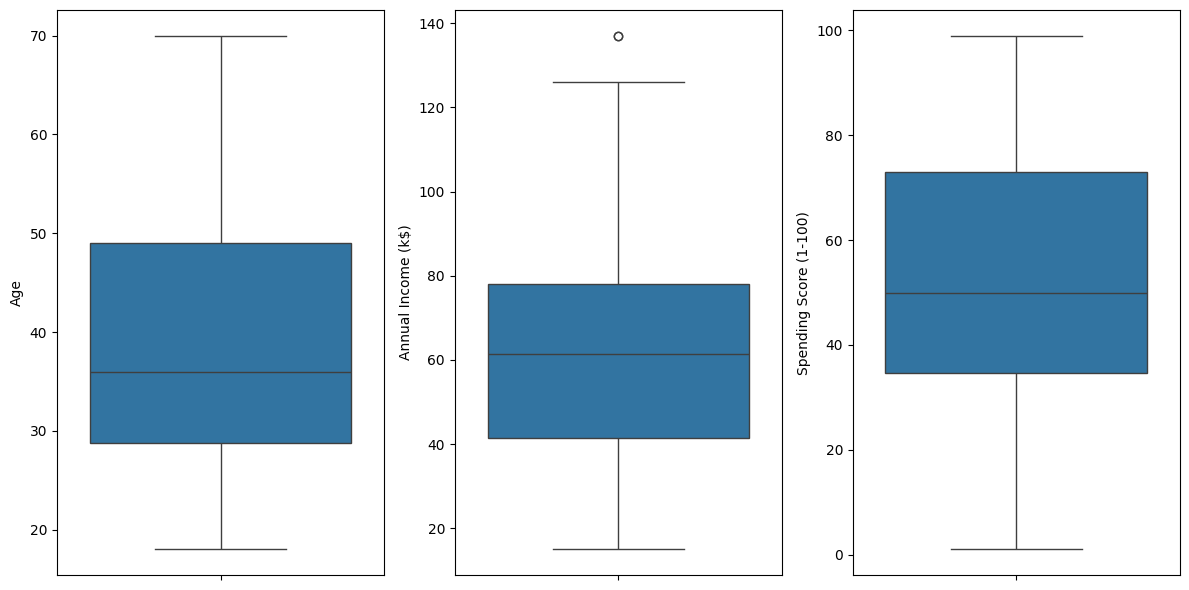

In [149]:
# Box plots for numerical columns
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y='Age', data=mall_customers_data)
plt.subplot(1, 3, 2)
sns.boxplot(y='Annual Income (k$)', data=mall_customers_data)
plt.subplot(1, 3, 3)
sns.boxplot(y='Spending Score (1-100)', data=mall_customers_data)
plt.tight_layout()
plt.show()

As you can see from boxplots above, there are only a few outliers in all dataset (these outliers are in Annual Income column). The fact that there are a few outliers in 200 record shows us these outliers can not effect on anything in our program, that is they are insignificant. We just simply remove them.

In [150]:
# Calculate the IQR for 'Annual Income'
Q1 = mall_customers_data['Annual Income (k$)'].quantile(0.25)
Q3 = mall_customers_data['Annual Income (k$)'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify and remove outliers
outliers = mall_customers_data[(mall_customers_data['Annual Income (k$)'] < lower_bound) | (mall_customers_data['Annual Income (k$)'] > upper_bound)]
mall_customers_data_no_outliers = mall_customers_data[~((mall_customers_data['Annual Income (k$)'] < lower_bound) | (mall_customers_data['Annual Income (k$)'] > upper_bound))]

# Display the identified outliers
print("Identified Outliers:")
print(outliers)

# Display the modified DataFrame without outliers
print("\nDataFrame without Outliers:")
print(mall_customers_data_no_outliers)


Identified Outliers:
     CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
198         199   Male   32                 137                      18
199         200   Male   30                 137                      83

DataFrame without Outliers:
     CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0             1    Male   19                  15                      39
1             2    Male   21                  15                      81
2             3  Female   20                  16                       6
3             4  Female   23                  16                      77
4             5  Female   31                  17                      40
..          ...     ...  ...                 ...                     ...
193         194  Female   38                 113                      91
194         195  Female   47                 120                      16
195         196  Female   35                 120                      79
196 

## 2. Data Preprocessing

* **Objective**: Transform raw data into a format suitable for ML algorithms: PCA, and clustering, such as normalization.

In [151]:
# Convert non-numeric values to numeric
mall_customers_data = mall_customers_data_no_outliers.copy()
map = {'Female': 1, 'Male': 0}
mall_customers_data['Gender'] = mall_customers_data_no_outliers['Gender'].map(map)
mall_customers_data
# Remove redundant columns such as CustomerID column
mall_customers_data = mall_customers_data.drop('CustomerID', axis=1)
mall_customers_data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0,19,15,39
1,0,21,15,81
2,1,20,16,6
3,1,23,16,77
4,1,31,17,40
...,...,...,...,...
193,1,38,113,91
194,1,47,120,16
195,1,35,120,79
196,1,45,126,28


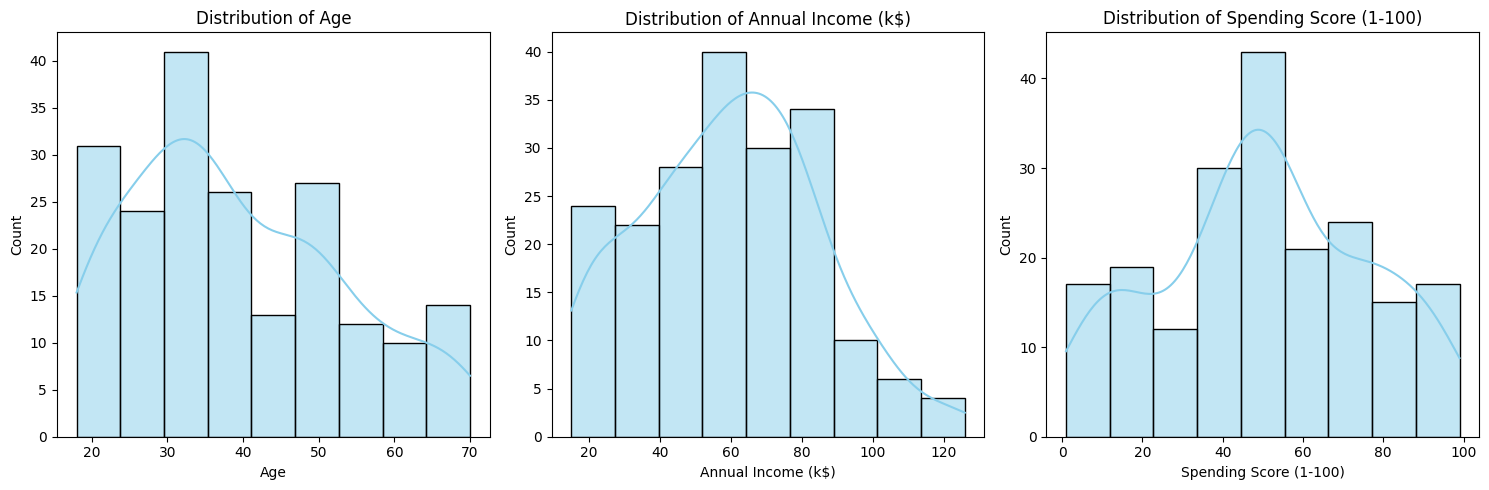

In [152]:
# Perform data normalization
# Before normalization, we want to visualize the data to understand it better so that we may able to choose best normalization technique for the data
selected_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(selected_features, 1):
    plt.subplot(1, len(selected_features), i)
    sns.histplot(mall_customers_data[feature], kde=True, color='skyblue')
    plt.title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

As you can see from above histograms, out data is normal and general distributed there is no outlier and there is no heavily skewness. Min-Max Scaling is a good general-purpose normalization technique and may be suitable for our data that does not have specific requirements.

In [153]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit and transform all columns
normalized_mall_customers_data = pd.DataFrame(scaler.fit_transform(mall_customers_data), columns=mall_customers_data.columns)
normalized_mall_customers_data

,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,0.0,0.019231,0.000000,0.387755
1,0.0,0.057692,0.000000,0.816327
2,1.0,0.038462,0.009009,0.051020
3,1.0,0.096154,0.009009,0.775510
4,1.0,0.250000,0.018018,0.397959
...,...,...,...,...
193,1.0,0.384615,0.882883,0.918367
194,1.0,0.557692,0.945946,0.153061
195,1.0,0.326923,0.945946,0.795918
196,1.0,0.519231,1.000000,0.275510


## 3. Dimensionality Reduction

### What is Dimensionality Reduction and Why is it Used?
Dimensionality reduction is the process of reducing the number of random variables under consideration by obtaining a set of principal variables. It is an attempt to reduce the complexity of the task as an attempt to remove the curse of dimensionality - also for visualization purposes.

### 3.1. Principal Component Analysis (PCA)
PCA is a technique that transforms original correlated features into new uncorrelated features (principal components) based on variance.
**Process:**
* **Linear Combinations of Features:** PCA begins by creating linear combinations of the existing features in the dataset.
* **First Principal Component:** The first principal component (PC1) is the linear combination that captures the highest variance in the dataset. Mathematically, this is the direction in which the data varies the most.
* **Subsequent Principal Components:** Each following principal component is the linear combination of features that captures the highest variance possible while being orthogonal (perpendicular) to all previously determined principal components. This ensures that each new principal component adds unique information.
* **Covariance Matrix and Eigenvectors:** The process of finding these principal components corresponds to computing the eigenvectors of the covariance matrix of the data. The covariance matrix encapsulates how each pair of variables in the dataset co-varies.
* **Eigenvalues:** The eigenvalues associated with each eigenvector (principal component) indicate the amount of variance that the principal component explains. Larger eigenvalues mean more variance explained.





### 3.2. Apply PCA
* Normalize the data
* Apply PCA to the normalized data using scikit-learn
* Visualize the data with the first two principal components (PC) as the axes. Do you see any clusters?
* Components selection: Visualize the variance explained by each PC. Then choose the number of components that explain the data sufficiently enough.

**Simply use the PCA from sklearn library**

In [154]:
# Apply PCA to the normalized data using scikit-learn
mall_customers_data = normalized_mall_customers_data.copy()
pca = PCA(n_components=4)
data_pca = pca.fit_transform(mall_customers_data)

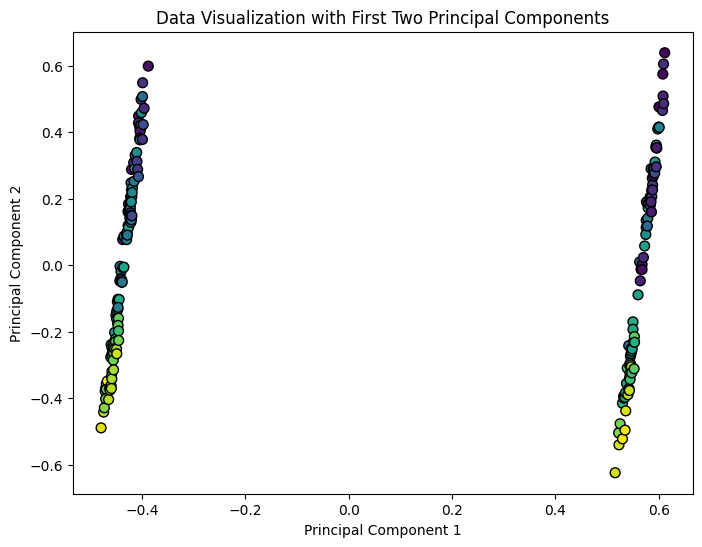

In [155]:
# Scatter plot of the first two principal components
y = mall_customers_data['Spending Score (1-100)']
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data Visualization with First Two Principal Components')
plt.show()

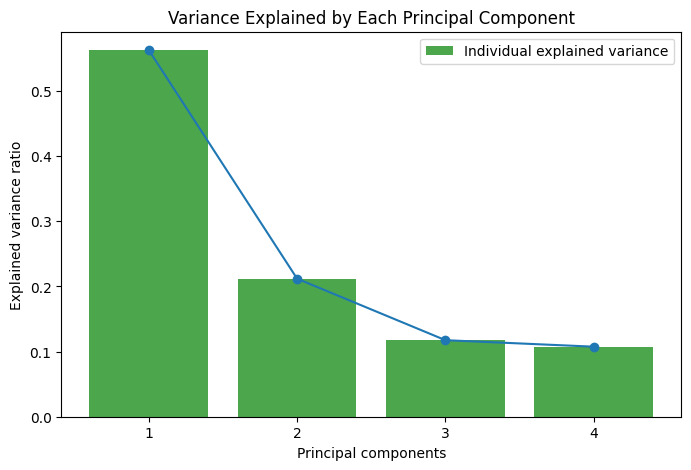

In [156]:
# Visualize the variance explained by each PC
explained_variance_ratio = pca.explained_variance_ratio_

# Plotting the Explained Variance Ratio
plt.figure(figsize=(8, 5))
plt.bar(range(1, 5), explained_variance_ratio, alpha=0.7, color='green', label='Individual explained variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('Variance Explained by Each Principal Component')
plt.xticks(range(1, 5))
plt.legend()
plt.show()

Let's choose the number of components that explain the data sufficiently enough
Typically, we would choose the number of components where adding more components does not result in a significant increase in the cumulative explained variance. This is often the point where the blue line starts to flatten out. So that the number of components that explain the data sufficiently enough is 2. 

## 4. Clustering on the Original Dataset

### 4.1. K-Means Clustering on the Original Dataset

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

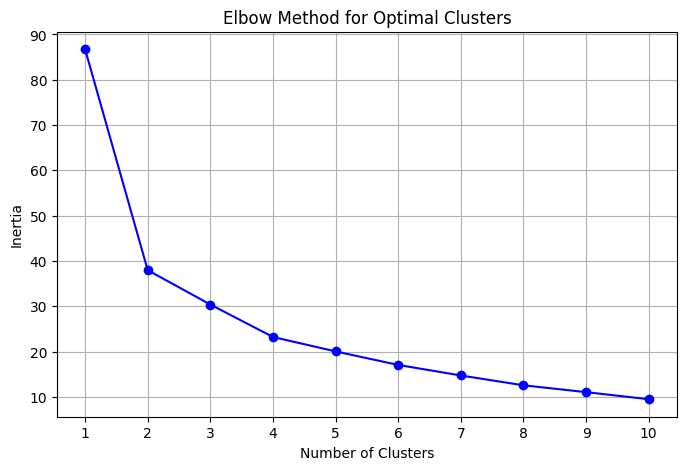

In [157]:
# Choose the optimal k using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(mall_customers_data)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', color='blue')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

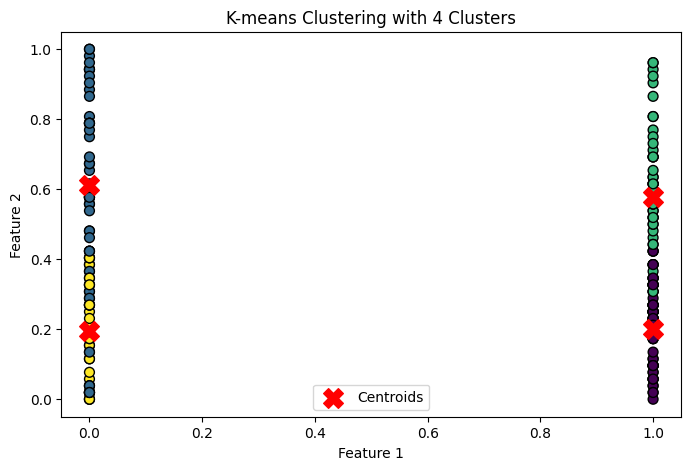

In [158]:
# Perform K-means clustering with k=4
optimal_k=4

kmeans = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
clusters = kmeans.fit_predict(mall_customers_data)

# Visualizing the clusters
plt.figure(figsize=(8, 5))
plt.scatter(mall_customers_data.iloc[:, 0], mall_customers_data.iloc[:, 1], c=clusters, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('K-means Clustering with 4 Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

### 4.2. Hierarchical Agglomerative Clustering (HAC) on the Original Dataset

Apply HAC on the dataset, visualize the dendogram. Then, comment on whether the dendogram agrees with the clusters obtained by K-Means. Try with 2 different linkage methods.

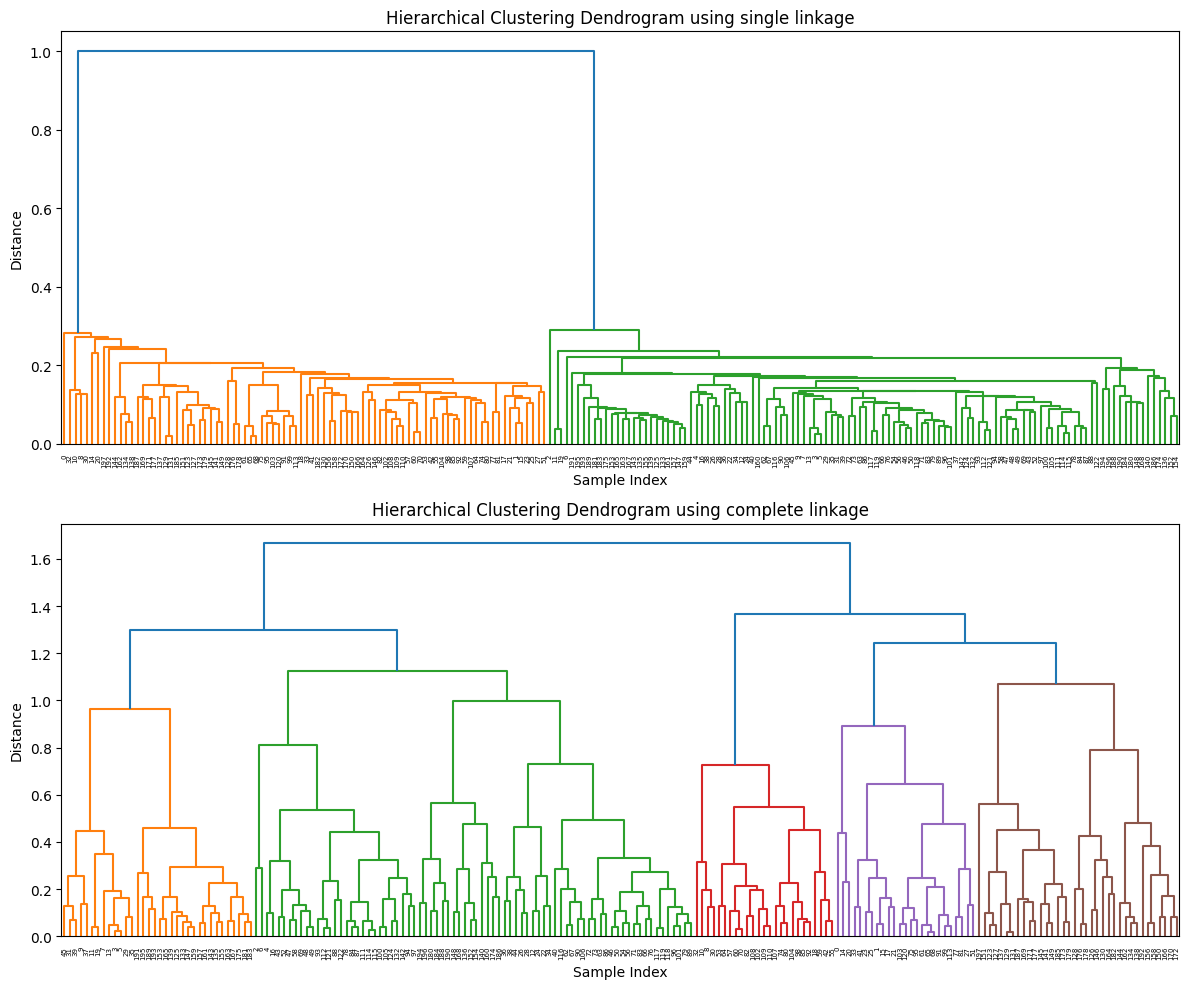

In [159]:
# Apply HAC on the dataset, visualize the dendogram

# Try with 2 different linkage methods.
linkage_methods = ['single', 'complete']

# Creating subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

for i, method in enumerate(linkage_methods):
    # Generate the linkage matrix
    Z = linkage(mall_customers_data, method=method)

    # Plotting the dendrogram
    axes[i].set_title(f'Hierarchical Clustering Dendrogram using {method} linkage')
    axes[i].set_xlabel('Sample Index')
    axes[i].set_ylabel('Distance')
    dendrogram(Z, ax=axes[i])

plt.tight_layout()
plt.show()

Both dendograms doesn't agree with the clusters obtained by K-Means.

## 5. K-means Clustering with PCA

Choose the optimal k using the Elbow method. Then, visualize the resulting clusters with that k.

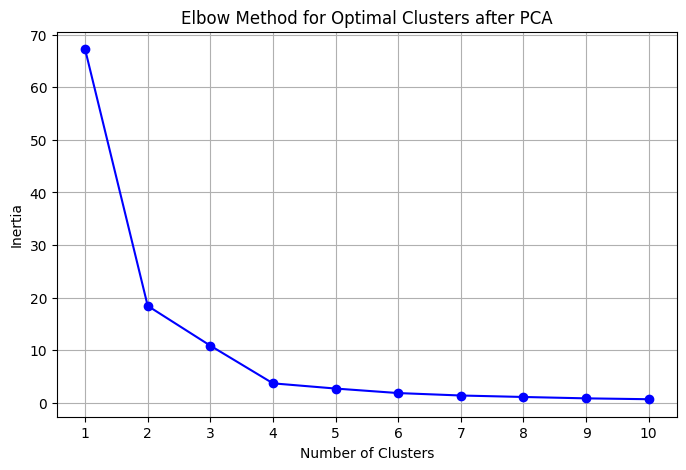

In [160]:
#Choose the optimal k using the Elbow method

# Firstly apply PCA for dimensionality reduction, we found 2 is sufficiant for PCA (the number of components that explain the data sufficiently)
pca = PCA(n_components=2) 
mall_customers_pca = pca.fit_transform(mall_customers_data)

# Choose the optimal k using the Elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10)
    kmeans.fit(mall_customers_pca)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method Graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o', color='blue')
plt.title('Elbow Method for Optimal Clusters after PCA')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

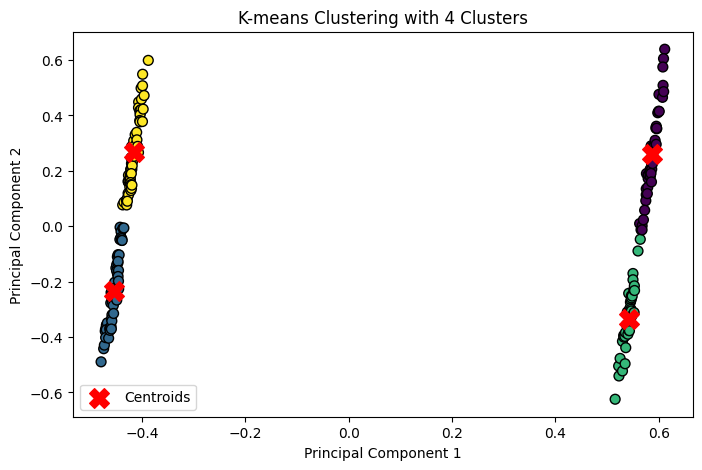

In [161]:
optimal_k = 4
# Perform K-Means clustering with the optimal k after PCA
kmeans_pca = KMeans(n_clusters=optimal_k, random_state=0, n_init=10)
clusters_pca = kmeans_pca.fit_predict(mall_customers_pca)

# Visualizing the clusters
plt.figure(figsize=(8, 5))
plt.scatter(mall_customers_pca[:, 0], mall_customers_pca[:, 1], c=clusters_pca, cmap='viridis', marker='o', edgecolor='k', s=50)
plt.scatter(kmeans_pca.cluster_centers_[:, 0], kmeans_pca.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.title('K-means Clustering with 4 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

## 6. Evaluate the Clustering Results

* Evaluate and compare the clustering results obtained in 4.1 and 5 (k means with and without PCA) using the Silhouette Coefficients.
* Which is better?

In [162]:
# Calculating the Silhouette Coefficients for 5 
silhouette_pca_avg = silhouette_score(mall_customers_data, clusters)
print(f"Silhouette Coefficient For Clusters Without PCA: {silhouette_pca_avg}")
# Calculating the Silhouette Coefficients for 4.1 
silhouette_avg = silhouette_score(mall_customers_pca, clusters_pca)
print(f"Silhouette Coefficient For Clusters With PCA: {silhouette_avg}")

Silhouette Coefficient For Clusters Without PCA: 0.3554256746559883
Silhouette Coefficient For Clusters With PCA: 0.6865398616690427


* A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
* So that when comparing different clusterings, a higher average Silhouette Coefficient indicates a better-defined clustering.
* In our case, the k-means clusters that are evaluated with PCA are better then clusters that are evaluated without PCA.
* Overall, results obtained in 5 are better then results obtained in 4.1